In [1]:
# 공통 영역
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

# 신경망 학습

- 학습이란
    - 가중치 매개변수의 최적값을 자동으로 획득하는 것

### 4.1.2 훈련데이터와 시험데이터

- 기계학습 문제는 데이터를 **훈련데이터**와 **시험데이터**로 나눠 학습과 실험을 수행하는게 일반적
- **범용능력**을 제대로 평가하기 위해 **시험데이터**와 분리함
- 한 데이터셋에만 지나치게 최적화 된 상태를 **과적합(overfitting)**이라고 함

## 4.2 손실 함수(loss function)
- 최적의 매개변수 값을 탐색할때 사용하는 지표를 **손실함수(loss function)**라고 함
- **비용함수(cost function)**라고도 함
- 일반적으로 오차제곱합과 교차 엔트로피 오차를 사용함
- 신경망 성능의 '나쁨'을 나타내는 지표. 적을수록 좋음

### 4.2.1 오차제곱합(Sum of Squares for Error, SSE)
- 가장 많이 쓰이는 손실 함수는 **오차제곱합(sum of squares for error, SSE)**

<img src="deep_learning_images/e 4.1.png"> 

- **원-핫 인코딩**: 한 원소만 1로 하고 그 외는 0으로 나타내는 표기법
    - ex) y = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

In [2]:
def sum_squares_error(y, t):
    return 0.5 * np.sum((y -t)**2)

### 교차 엔트로피 오차(Cross Entropy Error, CEE)

<img src="deep_learning_images/e 4.2.png"> 

- yk는 신경망의 출력
- tk는 정답레이블. 여기서 정답에 해당하는 인덱스의 원소만 1이고 나머지는 0임(원-핫인코딩)
- 정답일 때의 출력이 전체 값을 정함

(뭔소린지 이해못함)

In [3]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta)) # np.log() 함수에 0을 입력하면 -inf가 되어 아주작은 값 delta를 더해줌

In [4]:
t=[0,0,1,0,0,0,0,0,0,0]
y=[0.1,0.05,0.6,0.0,0.05,0.1,0.0,0.1,0.0,0.0]
cross_entropy_error(np.array(y),np.array(t))

0.510825457099338

In [5]:
y = [0.1,0.05,0.1,0.0,0.05,0.1,0.0,0.6,0.0,0.0]
cross_entropy_error(np.array(y), np.array(t))

2.302584092994546

### 4.2.3 미니배치학습

- 기계학습 문제는 훈련데이터를 사용해 학습함
- 훈련데이터에 대한 손실 함수의 값을 구하고, 그 값을 최대한 줄여주는 매개변수를 찾음

- 교차 엔트로피 오차는 아래 그림처럼 됨

<img src="deep_learning_images/e 4.3.png"> 

- 데이터가 N개 라면 tnk는 n번째 데이터의 k번째 값을 의미
- 마지막에 N을 나눠주는 이유는 **평균 손실 함수**를 구하기 위함

- 하지만 데이터가 많아 지면 속도가 많이 걸림
- 이를 현실적으로 계산하기 위해 훈련데이터의 _일부_를 추려 전체의 '근사치'로 이용
- 이 일부를 **미니배치(mini-batch)** 라고 하며 이러한 학습방법을 **미니배치 학습** 이라고 함

### 4.2.4 교차 엔트로피 구현

In [6]:
# y는 신경망의 출력, t는 정답 레이블
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.resahpe(1, t.size)
        y = y.reshape(1, y.size)
    if t.size == y.size:
        t = t.argmax(axis=1)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

## 4.3 수치 미분
- 경사법에서는 기울기(경사) 값을 기준으로 나아갈 방향을 정함

### 4.3.1 미분

<img src="deep_learning_images/e 4.4.png"> 

- x의 '작은 변화'가 함수 f(x)를 얼마나 변화시키느냐를 의미
- 시간을 뜻하는 h를 한없이 0에 가깝게 하여 구하는 식

In [7]:
# 수치미분(numerical differentiation)의 나쁜 구현 예시
def numerical_diff(f, x):
    h = 1e-50
    return (f(x + h) - f(x)) / h

- h에 가급적 작은 값을 대입하려고 1e-50 을 대입했으나 **반올림 오차(rounding error)** 문제를 일으킴

In [8]:
# 반올림 오차 예시
np.float32(1e-50)

0.0

<img src="deep_learning_images/fig 4-5.png" width="500" height="600">

- 위와 같이 수치미분에는 오차가 포함됨
- 이 오차를 줄이기 위해 (x + h)와 (x-h)일때의 함수 f의 차분을 계산
- 차분은 x를 중심으로 **중심 차분** 혹은 **중앙 차분** 이라고 함
- (x + h)와 x의 차분은 **전방차분** 이라고 함

In [9]:
# 개선된 수치미분 수식
def numerical_diff(f, x):
    h = 1e-4 # 0.0001
    return (f(x+h) - f(x-h)) / (2*h)

## 4.4 기울기(gradient)

- 모든 변수의 편미분을 벡터로 정리한 것

In [10]:
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # x와 형상이 같은 배열을 생성
    for idx in range(x.size):
        tmp_val = x[idx]
        # f(x + h)
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        # f(x - h)
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원
        
    return grad

<img src="deep_learning_images/fig 4-9.png" width="500" height="600">
<center>그림 4-9 f(x0, x1) = x0*x0 + x1*x1의 기울기</center>

- 위 그림처럼 기울기는 각 지점에서 낮아지는 방향을 가리킴
- **기울기가 가리키는 쪽은 각 장소에서 함수의 출력 값을 가장 크게 줄이는 방향**

### 4.4.1 경사 하강법(gradient descent method)

- 기울기를 활용해 손실 함수의 최솟값을 찾으려는 것
- 함수가 극솟값, 최솟값 또는 안정점(saddle pooint)이 되는 장소는 기울기가 0
- 경사가 여러곳인 함수라면 **고원(plateau)** 이라 하는 학습이 진행되지 않는 정체기에 빠질 수 있음

<img src="deep_learning_images/e 4.7.png"> 

- 위 수식에서 n 기호(eta)는 갱신하는 양을 나타냄
- 신경망 학습에서는 **학습률(learning rate)** 이라고 함
- 학습률 값은 미리 특정 값으로 정해두어야 하지만 값이 너무 크거나 작으면 '좋은 장소'를 찾아갈 수 없음

In [11]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x

    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x


def function_2(x):
    return x[0]**2 + x[1]**2

- 경사법으로 f(x0, x1) = x0*x0 + x1*x1의 최솟값을 구하는 문제

In [12]:
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x, lr=0.1)

array([-6.11110793e-10,  8.14814391e-10])

<img src="deep_learning_images/fig 4-10.png" width="500" height="600">
<center>그림 4-10</center>
- 점선은 함수의 등고선을 나타냄

In [13]:
# 학습률이 너무 큰 예 : lr = 10
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x, lr=10)

array([-2.58983747e+13, -1.29524862e+12])

In [14]:
# 학습률이 너무 작은 예 : lr = 1e-10
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x, lr=1e-10)

array([-2.99999994,  3.99999992])

- 학습률과 같은 매개변수를 **하이퍼파라미터(hyper parameter)** 라고 함


- 신경망의 가중치 매개변수는 훈련데이터와 학습 알고리즘에 의해 '자동'으로 획득되지만

  학습률같은 하이퍼파라미터는 사람이 직접 설정해야함
  
  학습시 매직넘버가 나타나길 기도하자

### 4.4.2 신경망에서의 기울기

- 여기서의 기울기란 가중치 매개변수에 대한 손실함수의 기울기를 뜻함

In [15]:
def softmax(a):
        c = np.max(a)
        exp_a = np.exp(a - c) # 오버플로 대책
        sum_exp_a = np.sum(exp_a)
        y = exp_a / sum_exp_a
        return y

In [16]:
class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # 정규분포로 초기화
        
    def softmax(a):
        c = np.max(a)
        exp_a = np.exp(a - c) # 오버플로 대책
        sum_exp_a = np.sum(exp_a)
        y = exp_a / sum_exp_a
        return y

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        return loss

In [17]:
net = simpleNet()
print(net.W)

[[ 0.61575707 -0.30287285 -0.66654809]
 [ 0.20423855 -0.06043728 -0.46434786]]


In [18]:
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)

[ 0.55326894 -0.23611727 -0.81784192]


In [19]:
np.argmax(p)

0

In [20]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [21]:
t = np.array([0, 0, 1]) # 정답 레이블
net.loss(x, t)

1.9064030075924556

In [22]:
def f(W):
    return net.loss(x, t)

In [23]:
# 책에서 나온수식말고 제공되는 코드로 해야 동작함
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        it.iternext()   
        
    return grad

In [24]:
dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.35129846  0.15953287 -0.51083132]
 [ 0.52694768  0.2392993  -0.76624698]]


## 4.5 학습 알고리즘 구현하기

### 학습 절차 복습

- 전제
    - 신경망에는 적응 가능한 가중치와 편향이 있음
    - 이 가중치와 편향을 훈련 데이터에 적응하도록 조절하는 과정을 '학습'이라고 함
- 1단계 - 미니배치
    - 훈련 데이터 중 일부를 가져옴
    - 가져온 일부 데이터를 미니배치라 함
    - 위 데이터의 솔실함수 값을 줄이는 것이 목표
- 2단계 - 기울기 산출
    - 미니배치의 손실 함수 값을 줄이기 위해 각 매개변수의 기울기를 구함
    - 기울기는 손실 함수의 값을 가장 작게 하는 방향을 제시
- 3단계 - 매개변수 갱신
    - 가중치 매개변수를 기울기 방향으로 아주 조금 갱신
- 4단계 - 반복
    - 1 ~ 3 단계를 반복

- 확률적 경사 하강법(SGD: stochastic gradient descent)
    - 학습 _`데이터를 확률적으로 무작위로 골라내어 선정`_ 하기 때문에 이와같이 불림
    - 대부분의 딥러닝 프레임워크는 SGD함수로 이 기능을 구현함

### 4.5.1 2층 신경망 클래스 구현

In [25]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))    


def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

In [26]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

In [27]:
net = TwoLayerNet(784, 100, 10)

In [28]:
net.params['W1'].shape

(784, 100)

In [29]:
net.params['b1'].shape

(100,)

In [30]:
net.params['W2'].shape

(100, 10)

In [31]:
net.params['b2'].shape

(10,)

In [32]:
# 더미 입력 데이터(100장 분량)
x = np.random.rand(100, 784)
# 더미 정답 레이블(100장 분량)
t = np.random.rand(100, 10)

In [33]:
# 기울기 계산
# grads = net.numerical_gradient(x, t)

In [34]:
# 시간 오래걸리니 아래 함수 쓰라고 함
# 다음장에서 사용할 오차 역전파법
# 미분을 사용할 때 와 거의 같은 결과를 빠르게 얻을 수 있음
grads = net.gradient(x, t)

In [35]:
grads['W1'].shape

(784, 100)

In [36]:
grads['b1'].shape

(100,)

In [37]:
grads['W2'].shape

(100, 10)

In [38]:
grads['b2'].shape

(10,)

### 4.5.2 미니배치 학습 구현

In [48]:
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

In [55]:
# 하이퍼파라미터
iters_num = 1000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.5

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

In [56]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [57]:
for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))


train acc, test acc | 0.10218333333333333, 0.101
train acc, test acc | 0.11236666666666667, 0.1135


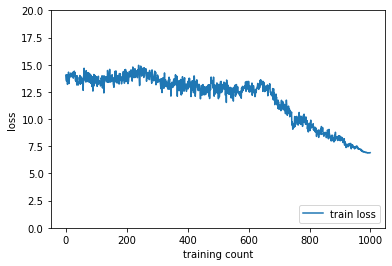

In [43]:
# 그래프 그리기
markers = {'train': 'o'}
x = np.arange(len(train_loss_list))

plt.plot(x, np.flip(train_loss_list), label='train loss')
plt.xlabel("training count")
plt.ylabel("loss")
plt.ylim(0, 20.0)
plt.legend(loc='lower right')
plt.show()

In [58]:
# 하이퍼파라미터
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.5

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

In [59]:
for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))


train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.11236666666666667, 0.1135


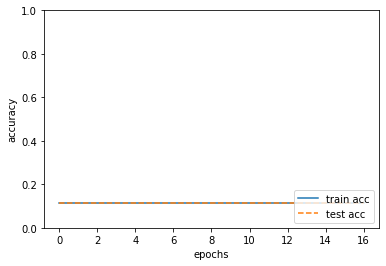

In [60]:
# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

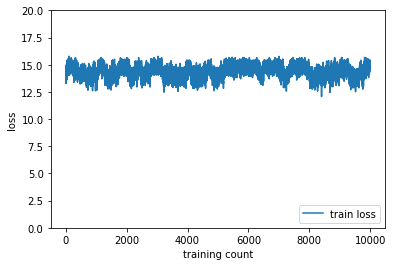

In [61]:
# 손실률 그래프 그리기
markers = {'train': 'o'}

x = np.arange(len(train_loss_list))

plt.plot(x, np.flip(train_loss_list), label='train loss')
plt.xlabel("training count")
plt.ylabel("loss")
plt.ylim(0, 20.0)
plt.legend(loc='lower right')
plt.show()